### Global parameters 

You will need to have set up a [Karst account](https://kb.iu.edu/d/bezu#account) first. Once you have your Karst account simply go to [rstudio.iu.edu](https://rstudio.iu.edu/auth-sign-in) and login using your IU username and passphrase.  Next, set the working directory by pointing to the location on Karst where you have stored the files. Below, we have chosen to save the folder "Text-Analysis" as a "Project" in R Studio on the Karst super-computer here at Indiana University. It contains the R scripts, texts, notebooks, and results. If you have forked and cloned the Github repository (see [textPrep.Rmd](textPrep.Rmd) for directions on how), simply point to where you have saved the folder. If you save it to your personal Karst folder, it will most likely look very similar to the example below. Karst is a unix server and so the home directory is represented by a ~ and, thus, the path will look like this "~/Text-Analysis/" (with the quotes). Alternatively, if you are on a PC, you will need to use an absolute path such as "C:/Users/XXX" (with the quotes again).

In R Studio, click Session in the menu bar > Set Working Directory > Choose Directory, then select the Text-Analysis directory in which you are working. This will set your working directory in the console pane, but make sure to copy the path into the source pane above to keep the directory constant if you close this script and reopen later. Make sure you click on the blue cube with a "R" in the center to set your working directory to your Text-Analysis project path.

HINT: Your working directory is the folder from which you will be pulling your texts.

In [1]:
setwd("~/Text-Analysis")

#### Include necessary packages for notebook 

R's extensibility comes in large part from packages. Packages are groups of functions, data, and algorithms that allow users to easily carry out processes without recreating the wheel. Some packages are included in the basic installation of R, others created by R users are available for download. Make sure to have the following packages installed before beginning so that they can be accessed while running the scripts.

In R Studio, packages can be installed by navigating to Tools in the menu bar > Install Packages. Or in the bottom right panel click on the "packages" tab and then click on "install."

In [2]:
library(wordcloud)
library(tm)
library(RColorBrewer)
library(twitteR)

Loading required package: RColorBrewer
Loading required package: NLP


Load data (this time a curated set of tweets grabbed using the twitterR library and API authentication, then saved with the .RData extension)

In [3]:
load("data/twitter/HillaryOct4.RData")

### Prepare text data

While it seems logical to use tm (text mining package) again to create our wordcloud, there is a bug in the library that causes it to fail with this kind of data when run on a mac. Instead, we will take the opportunity to process the data in a different way.

First we are going to take the list of 5000 tweets created when we grabbed the file above and convert it into a character vector, grabbing only the text. The "sapply" function to traverse the list "tweets" applying a function "x" which grabs the text. 

In [4]:
tweets_text <- sapply(tweets, function(x) x$text)

Let's look at the first few tweets:

In [5]:
head(tweets_text)

[1] "RT @mitchellvii: For an \"unbiased polling analyst,\" @NateSilver538 seems awfully invested in a Hillary win."                                       
[2] "VIDEO : What Does it Say About Hillary That Her Campaign Manager is an Inept, Befuddled Mess?… https://t.co/YAm3KbC4tF"                              
[3] "VIDEO : What Does it Say About Hillary That Her Campaign Manager is an Inept, Befuddled Mess?… https://t.co/oDeRZZx9E4"                              
[4] "BREAKING : Racist and Pandering Hillary Says WHITE PEOPLE Don’t WORRY About Their Kids https://t.co/xNjcsboAEw https://t.co/MHbFKKGSOu"              
[5] "RT @0HOUR1__: How do you think Bill Clinton &amp; Hillary Clinton tent city made out in that cat 4 Hurricane  built sweatshops &amp; mining factory…"
[6] "RT @peterdaou: #MorningJoe having a meltdown this morning over #Hillary's resurgent poll numbers. They can't face it."

Now we need to turn the character vector into a corpus:

In [6]:
corpus <- Corpus(VectorSource(tweets_text))

Next, we need to convert the text to UTF-8 as sometimes the program has difficulty reading the characters:

In [7]:
corpus <- tm_map(corpus,
                 content_transformer(function(x) iconv(x, "ASCII", "UTF-8", sub="")))

Now we need to convert all the text to lower case, so that "Clinton" and "clinton" are not seen as seperate words.

In [8]:
corpus <- tm_map(corpus, content_transformer(tolower))

Now we need to remove all punctuation so that only alphanumeric characters are read:

In [9]:
corpus <- tm_map(corpus, removePunctuation)

You may also wish to eliminate numbers, especially if they skew your results any, however, numbers may also be important, so that is why this one is optional:

In [10]:
corpus <- tm_map(corpus, removeNumbers)

It's time to remove stopwords. In our plain text wordcloud, we used tm's options for a wordlist and will be doing the same again. Concatenated onto the list are common twitter words not yet eliminated such as "rt" (retweet), "amp" (&), and the subject of our tweets "hillary."

In [11]:
corpus <- tm_map(corpus, removeWords, c(stopwords("english"),'amp','rt','http', 'https','httpstc','httpst','httpstco', 'marketing', 'hillary', 'dont'))

Plot the wordcloud! There are a number of arguments you can customize: "scale"" indicates the size of the words; "max.words" controls how many words show up in the wordcloud; and we've used the library "RColorBrewer" to give us access to some predefined palettes. Note that if you change the palette, you need to tell the argument how many colors are in the new palette. 

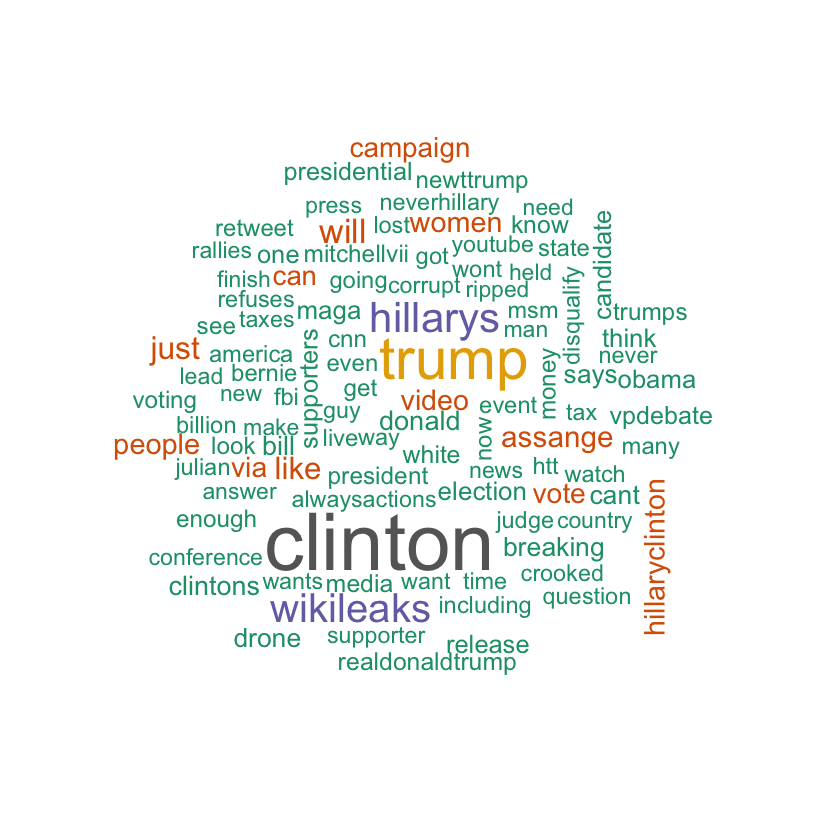

In [12]:
wordcloud(corpus, min.freq=10, max.words=100, scale=c(4,1), colors=brewer.pal(8, "Dark2"))

### VOILA!